In [ ]:
import re
import time
import csv
from itertools import product
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import (train_test_split, cross_validate,
                                     learning_curve, GridSearchCV, KFold)
from sklearn.metrics import (make_scorer, accuracy_score,
                             confusion_matrix, f1_score,
                             precision_score, recall_score,
                             roc_auc_score)
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer,
                                             HashingVectorizer)
from sklearn.decomposition import TruncatedSVD

In [ ]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [ ]:
import fasttext

**На мой взгляд, решение тестового задания заключается не только в предоставлении лучшей модели и предсказаний, но и демонстрация поиска этой самой модели – рассуждения, попытки. По этой причине решила оставить большую часть из "черновика". Правда я понимаю, что силы и время проверяющих имеют предел. Поэтому, если хочется посмотреть на финальный результат, то переходите к разделу "Обучение и предсказание".**

*Что входило в перебор:*

* Предобработка текста (лемматизация, пунктуация)
* Подбор векторизации (CountVectorizer, HashingVectorizer, TfidfVectorizer, SVD, FastText)
* Модели (LogisticRegression, SVC(kernel='linear'), SVC(kernel='rbf'), KNeighborsClassifier, MLP, RandomForestClassifier, MultinomialNB, FastText, XGBClassifier, StackingClassifier с различными комбинациями)
          
*Я рассмотрела практически все возможные комбинации (некоторая часть перебора осталась в черновом варианте ноутбука), пробовала подбирать гиперпараметры. В финальное решение, которое показало наилучший результат, попало векторное представление текста с помощью FastText и SVC с гауссовым ядром.*

Предварительная обработка текста (создание файлов с чистыми данными в том числе) вынесена в отдельный ноутбук "analysis_preprocessing".

In [ ]:
# Вспомогательные функции

def get_pipe(model, vect, svd=False, dense_sparse=False):
    """
    Creates and returns a Pipeline.
    Parameters
    ----------
    model : object
        A model for approximating the data. It is assumed to be 
        a sklearn model.
    vect : object
        Convert the text into a feature vector.
    svd : bool, default=False
        Using SVD decomposition. 
    dense_sparse : bool, default=False
        Applies to a sparse matrix.
    """
    transformer = FunctionTransformer(lambda x: np.asarray(x.todense()),
                                      accept_sparse=True)
    base_pipe = [("vect", vect), ("cls", model)]
    if svd:
        base_pipe.insert(1, ('svd', TruncatedSVD()))
    if dense_sparse:
        base_pipe.insert(-1, ('dens', transformer))
    return Pipeline(base_pipe)


def highlight_max(s, props=''):
    """
    Highlights the maximum values in colour.
    """
    return np.where(s == np.nanmax(s.values), props, '')


def colorize_df(pv):
    """
    Highlights the maximum values in colour for the column.
    Highlights the cell in the table with the colour of the maximum value.
    """
    pv_c = pv.style.apply(highlight_max, props='color:green', axis=0)\
             .apply(highlight_max, props='color:white;background-color:green',
                    axis=None)
    return pv_c


def plot_learning_curve(vect):
    if type(vect) is type(HashingVectorizer()):
        fig, axes = plt.subplots(2, 3, figsize=(20, 15))
    else: 
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    ind_sub = list(product(range(3), repeat=2))
    ts = np.linspace(0.6, 1, 7)

    for i, item in enumerate(models.items()):
        name, model = item
        title = f'Learning Curves ({name})'
        if name == 'MultinomialNB' and type(vect) is type(HashingVectorizer()):
            continue
        else:
            pipe = get_pipe(model, vect=vect)
        train_sz, train_score, test_score = learning_curve(pipe, X_train, y_train, 
                                                           cv=5, random_state=42,
                                                           scoring=scoring['f1'],
                                                           train_sizes=ts,
                                                           n_jobs=-1)
        x, y = train_sz, np.mean(train_score, axis=1)
        axes[ind_sub[i][0], ind_sub[i][1]].plot(x, y, label='train')
        x, y = train_sz, np.mean(test_score, axis=1)
        axes[ind_sub[i][0], ind_sub[i][1]].plot(x, y, label='test')
        axes[ind_sub[i][0], ind_sub[i][1]].legend()
        axes[ind_sub[i][0], ind_sub[i][1]].set_title(title)


def convertdt_fasttext(y, x):
    """
    Converting data into input format for FastText.
    """
    ds = pd.DataFrame(y, columns=['is_fake'])
    ds['is_fake'] = ds['is_fake'].apply(lambda x: f'__label__{x}')
    ds['sent'] = x
    return ds


def save_ds(ds, name='train.txt'):
    """
    Saving data for FastText.
    """
    ds.to_csv(name, 
              index=False, 
              sep=' ',
              header=None, 
              quoting=csv.QUOTE_NONE, 
              quotechar="", 
              escapechar=" ")


def predict_convert(model, data, return_prob=False):
    """
    Predicting and converting class labels for FastText.
    """
    prob = []
    label = []
    for header in data:
        l, p = model.predict(header)
        label.append(int(l[0][-1]))
        prob.append(p[0])
    if return_prob:
        return label, prob
    return label

In [ ]:
df = pd.read_csv(f'clean_data.csv')
X, Y = df['title_new'].tolist(), df['is_fake']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1,
                                                    random_state=42)

In [ ]:
len(y_test), len(y_train)

(576, 5181)

In [ ]:
y_train.value_counts()  # сбалансированная выборка

1    2603
0    2578
Name: is_fake, dtype: int64

In [ ]:
y_test.value_counts()

0    300
1    276
Name: is_fake, dtype: int64

*Для начала хочется просто посмотреть, как себя покажут стандартные векторайзеры и алгоритмы классификации. Поэтому проведем исследование по основным на нашем наборе данных. Предположительно TF-IDF вместе с логистической регрессией, наивный байесовский классификатор должны сразу дать неплохие результаты. KNN и деревья (лес), скорее всего, дадут довольно низкий score для задачи классификации текста. Качество моделей, конечно, будем измерять на cross-validate, усредняя.*

In [ ]:
models = {'LogisticRegression': LogisticRegression(random_state=42, n_jobs=2),
          'SVC_lin': SVC(kernel='linear', random_state=42),
          'SVC_g': SVC(kernel='rbf', random_state=42),
          'KNeighborsClassifier': KNeighborsClassifier(n_jobs=2),
          'MLP': MLPClassifier(max_iter=800, random_state=42),
          'RandomForestClassifier': RandomForestClassifier(random_state=42,
                                                           n_jobs=2),
          'MultinomialNB': MultinomialNB()}

In [ ]:
vectorizers = {'CountVectorizer': CountVectorizer(lowercase=False),
               'TfidfVectorizer': TfidfVectorizer(lowercase=False),
               'HashingVectorizer': HashingVectorizer(lowercase=False,
                                                      n_features=20000)}

In [ ]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'f1': make_scorer(f1_score)}

In [ ]:
res_metrics = dict()
for name_model, model in models.items():
    for name_vect, vect in vectorizers.items():
        for svd in [True, False]:
            # svd и HashingVectorizer приводят к ошибкам в MultinomialNB
            # из-за отрицательных значений после векторного представления или разложения
            if (name_vect == 'HashingVectorizer' or svd) and \
                name_model == 'MultinomialNB':  
                    continue
            pipe = get_pipe(model, vect, svd)
            name_for_res = (name_model, name_vect, svd)
            res_metrics[name_for_res] = cross_validate(pipe, X_train, y_train, verbose=2,
                                                       n_jobs=-1, scoring=scoring, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5

In [ ]:
analysis = []
for clf, met in res_metrics.items():
    analysis.append([])
    analysis[-1].extend(clf)
    analysis[-1].extend([np.mean(met['test_accuracy']),
                         np.mean(met['test_precision']),
                         np.mean(met['test_recall']),
                         np.mean(met['test_f1'])])

In [ ]:
col = ['model', 'vect', 'svd', 'accuracy', 'precision', 'recall', 'f1']
res = pd.DataFrame(analysis, columns=col)

In [ ]:
res

,model,vect,svd,accuracy,precision,recall,f1
0,LogisticRegression,CountVectorizer,True,0.554334,0.583965,0.394166,0.470439
1,LogisticRegression,CountVectorizer,False,0.824553,0.869320,0.766428,0.814423
2,LogisticRegression,TfidfVectorizer,True,0.567848,0.578922,0.514041,0.544279
3,LogisticRegression,TfidfVectorizer,False,0.811431,0.797071,0.838650,0.817161
4,LogisticRegression,HashingVectorizer,True,0.557230,0.580587,0.428362,0.492618
5,LogisticRegression,HashingVectorizer,False,0.783443,0.795316,0.766808,0.780722
6,SVC_lin,CountVectorizer,True,0.548351,0.584661,0.352291,0.439226
7,SVC_lin,CountVectorizer,False,0.818957,0.867242,0.756054,0.807562
8,SVC_lin,TfidfVectorizer,True,0.542367,0.576839,0.337699,0.425490
9,SVC_lin,TfidfVectorizer,False,0.821465,0.809755,0.842878,0.825903


In [ ]:
res.groupby('model', as_index=False).agg({'f1':max})

,model,f1
0,KNeighborsClassifier,0.775673
1,LogisticRegression,0.817161
2,MLP,0.832660
3,MultinomialNB,0.839383
4,RandomForestClassifier,0.745956
5,SVC_g,0.822812
6,SVC_lin,0.825903


In [ ]:
col = ['model', 'accuracy', 'precision', 'recall', 'f1']
res[col].groupby('model', as_index=False).agg(np.mean)

In [ ]:
res[res['svd'] == True][['accuracy', 'precision', 'recall', 'f1']].mean()

accuracy     0.580145
precision    0.592277
recall       0.521932
f1           0.548525
dtype: float64

In [ ]:
res[res['svd'] == False][['accuracy', 'precision', 'recall', 'f1']].mean()

accuracy     0.780441
precision    0.818048
recall       0.727858
f1           0.760141
dtype: float64

*Уже тут видно, что в среднем модели без SVD-разложения дают лучше результаты. Поэтому в дальнейшем я откажусь от этого.*

In [ ]:
pv = pd.pivot_table(res, values=['f1'], columns=['model'],
                    index=['vect', 'svd'], aggfunc=max)

In [ ]:
pv_c = colorize_df(pv)

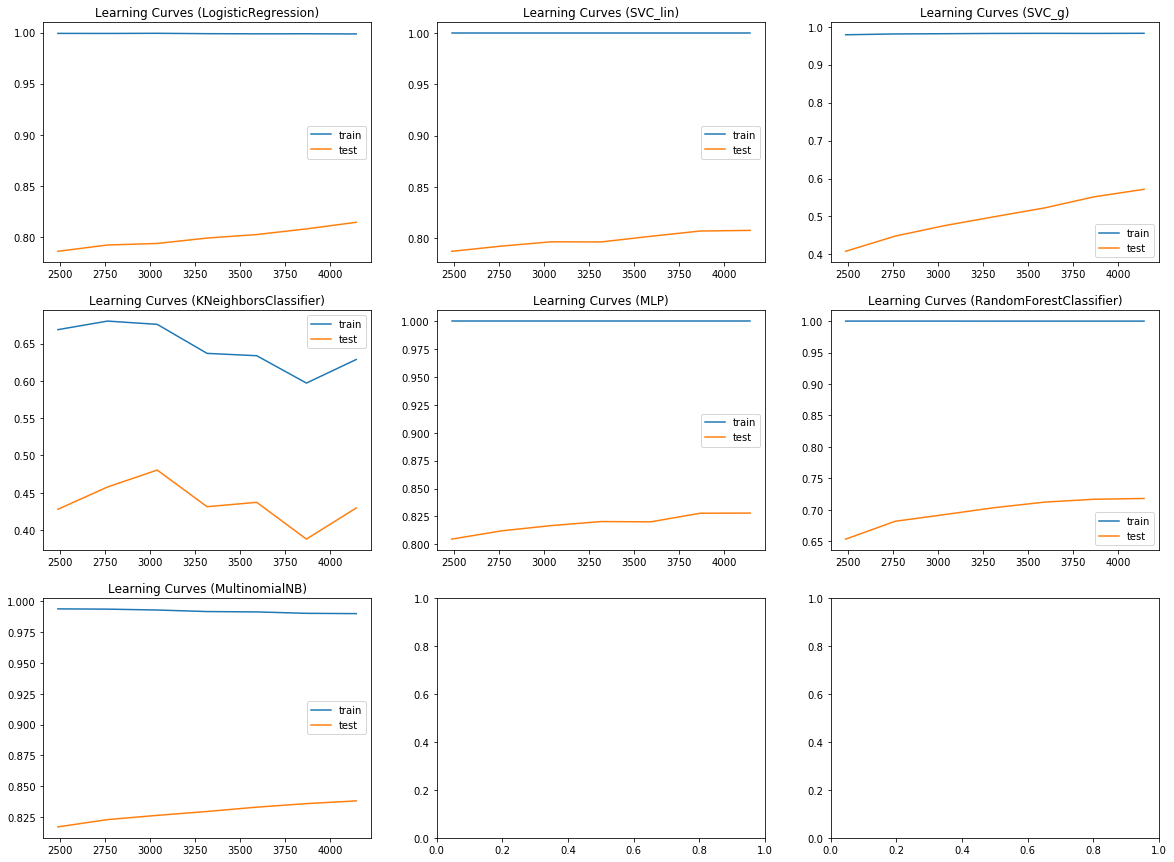

In [ ]:
plot_learning_curve(vectorizers['CountVectorizer'])

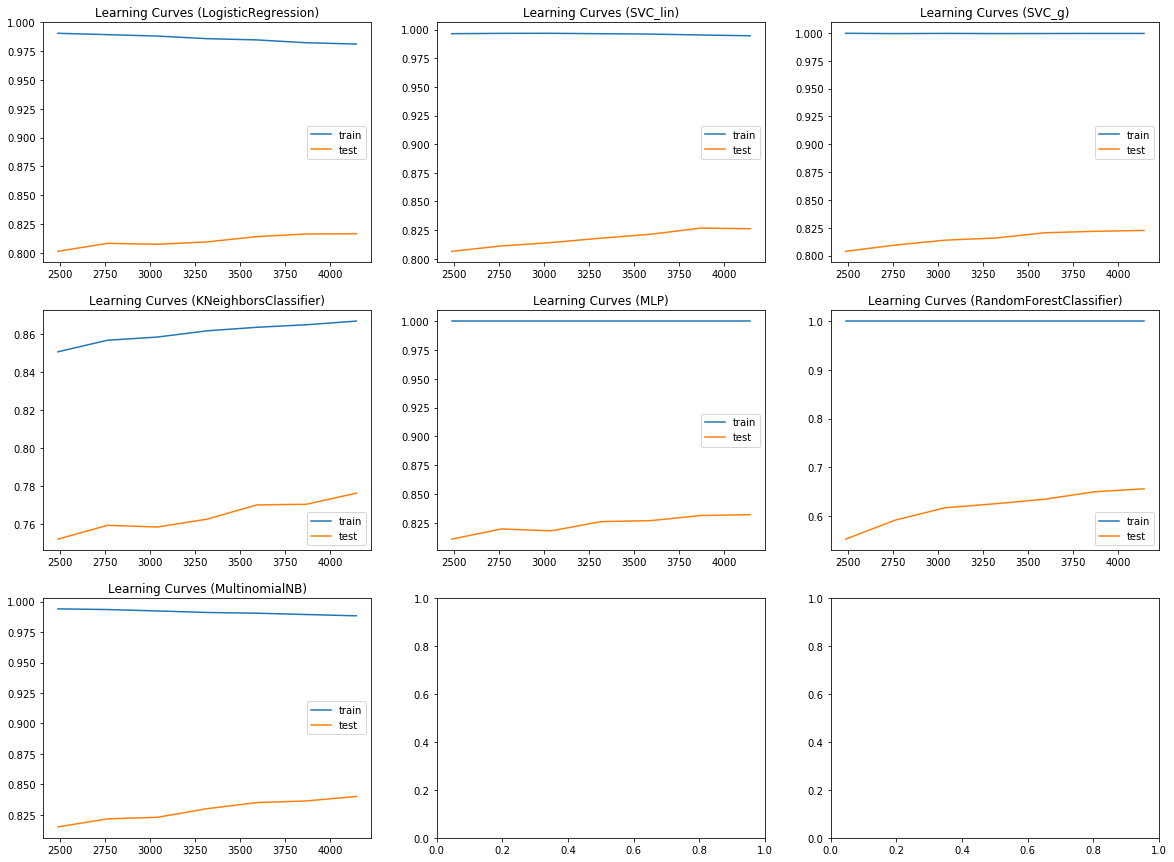

In [ ]:
plot_learning_curve(vectorizers['TfidfVectorizer']) 

/Users/tatyana/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


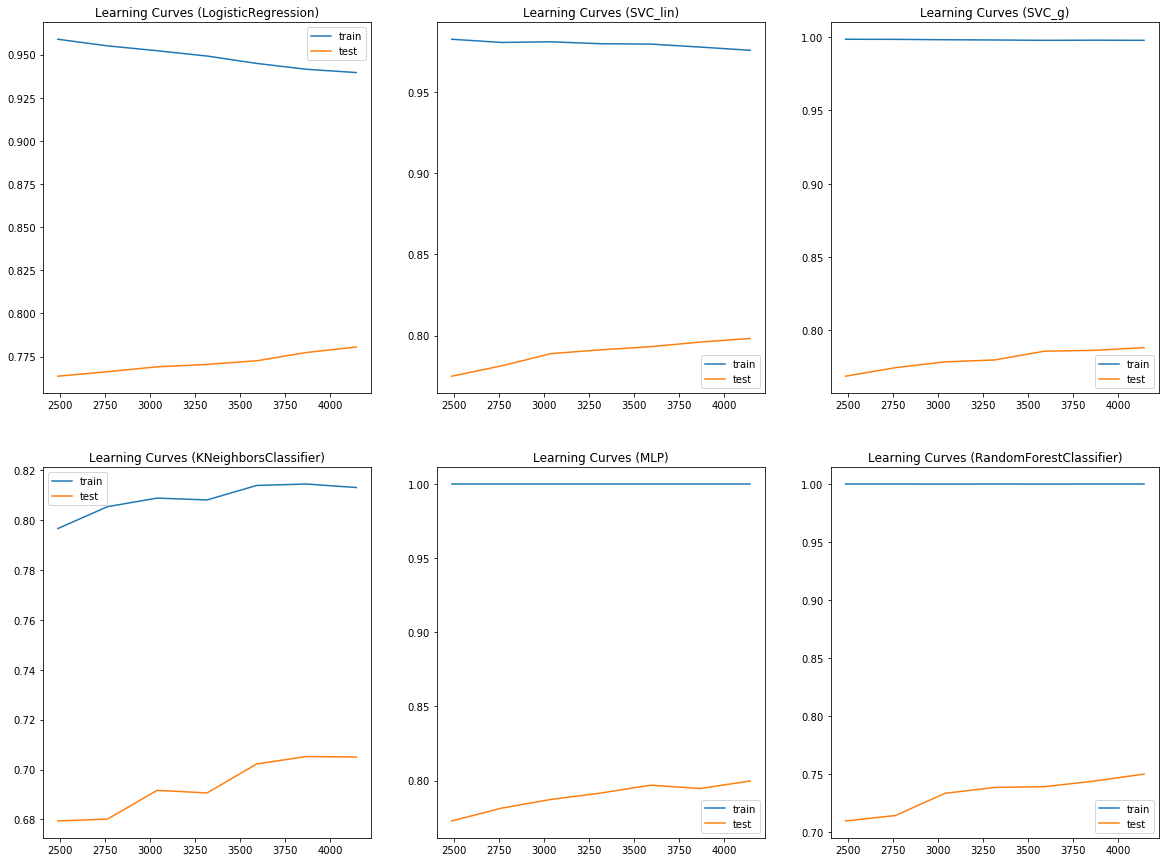

In [ ]:
plot_learning_curve(vectorizers['HashingVectorizer'])

*По кривым обучения очевидно, что все модели получились переобученными. Попробуем это исправить с помощью регуляризации. Также с помощью перебора гиперпараметров можно улучшить качество моделей. Полный перебор параметров (для всех векторайзеров и для всех моделей) будет очень расточительным. Поэтому будем подбирать поэтапно. Сначала определимся с лучшим векторным представлением для каждого алгоритма классификации.*

In [ ]:
param_vect = {
               'CountVectorizer': {'vect__max_features': [None, 5000, 10_000, 15_000],
                                   'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                                   'vect__stop_words': [None, {'english', 'russian'}]},                         
    
               'TfidfVectorizer': {'vect__max_features': [None, 5000, 10_000, 15_000],
                                   'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                                   'vect__stop_words': [None, {'english', 'russian'}],
                                   'vect__norm': ['l1', 'l2']},                       
              
               'HashingVectorizer': {'vect__n_features': [5000, 10_000, 15_000],
                                     'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                                     'vect__stop_words': [None, {'english', 'russian'}],
                                     'vect__norm': ['l1', 'l2']}
             }                        

In [ ]:
vect_gscv = dict()
for name_model, model in models.items():
    for name_vect, vect in vectorizers.items():
        if name_vect == 'HashingVectorizer' and name_model == 'MultinomialNB':
                    continue
        pipe = get_pipe(model, vect)
        gscv = GridSearchCV(pipe, param_vect[name_vect],
                            cv=5, n_jobs=-1,
                            scoring=scoring['f1'], 
                            verbose=2,
                            error_score='raise')
        gscv.fit(X_train, y_train)
        vect_gscv[(name_model, name_vect)] = [gscv.best_params_, gscv.best_score_]

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 

In [ ]:
choice_vect = []
for mod, best in vect_gscv.items():
    choice_vect.append([])
    choice_vect[-1].extend(mod)
    choice_vect[-1].extend(best)

In [ ]:
ch_vect = pd.DataFrame(choice_vect, columns=['cls', 'vect', 'param', 'f1'])

In [ ]:
pv_vect = pd.pivot_table(ch_vect, values=['f1'], 
                         columns=['cls'], index=['vect'], aggfunc=max)

*Посмотрим на новые результаты. Видно, что в большинстве случаев немного настроенный TF-IDF оказался лучше. Зафиксируем отобранные векторайзеры для моделей.*

In [ ]:
pv_vect_c = colorize_df(pv_vect)
pv_vect_c  # новые

In [ ]:
pv_c  # старые

In [ ]:
vect_gscv[('RandomForestClassifier', 'HashingVectorizer')][0]

{'vect__n_features': 10000,
 'vect__ngram_range': (1, 1),
 'vect__norm': 'l2',
 'vect__stop_words': None}

In [ ]:
for name_model, model in models.items():
    if name_model == 'RandomForestClassifier':
        continue
    print(f'{name_model}:\n{vect_gscv[(name_model, "TfidfVectorizer")][0]}\n')

LogisticRegression:
{'vect__max_features': None, 'vect__ngram_range': (1, 2), 'vect__norm': 'l2', 'vect__stop_words': None}

SVC_lin:
{'vect__max_features': None, 'vect__ngram_range': (1, 2), 'vect__norm': 'l2', 'vect__stop_words': None}

SVC_g:
{'vect__max_features': None, 'vect__ngram_range': (1, 2), 'vect__norm': 'l2', 'vect__stop_words': None}

KNeighborsClassifier:
{'vect__max_features': None, 'vect__ngram_range': (1, 1), 'vect__norm': 'l2', 'vect__stop_words': None}

MLP:
{'vect__max_features': None, 'vect__ngram_range': (1, 2), 'vect__norm': 'l1', 'vect__stop_words': None}

MultinomialNB:
{'vect__max_features': None, 'vect__ngram_range': (1, 3), 'vect__norm': 'l2', 'vect__stop_words': None}



In [ ]:
best_vect = {'LogisticRegression': TfidfVectorizer(lowercase=False, ngram_range=(1, 2)),
                   
             'SVC_lin': TfidfVectorizer(lowercase=False, ngram_range=(1, 2)),

             'SVC_g': TfidfVectorizer(lowercase=False, ngram_range=(1, 2)),

             'KNeighborsClassifier': TfidfVectorizer(lowercase=False),

             'MLP': TfidfVectorizer(lowercase=False, ngram_range=(1, 2), norm='l1'),

             'RandomForestClassifier': HashingVectorizer(lowercase=False, n_features=10000),

             'MultinomialNB': TfidfVectorizer(lowercase=False, ngram_range=(1, 3))}

*Далее пропущен небольшой кусок кода из черновика. Чтобы попытаться улучшить качество моделей с новыми векторами, я делала перебор параметров для самих классификаторов. Однако полный перебор по всем возможным сочетаниям был бы весьма трудоемким. Поэтому сначала я подобрала гиперпараметры, которые сильнее всего влияют на обучение модели. А затем уже дотюнила с помощью сетки GridSearchCV.*

In [ ]:
param_model = {'LogisticRegression': {'cls__solver': ['saga'],
                                      'cls__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                                      'cls__C': [0.1, 1, 10],
                                      'cls__max_iter': [200, 250],
                                      'cls__l1_ratio': [0, 1, 0.5]},
              
               'SVC_lin': {'cls__C': [1, 10, 15]},
              
               'SVC_g': {'cls__C': [1, 10, 15]},
              
               'KNeighborsClassifier': {'cls__n_neighbors' : np.arange(5, 15, 2),
                                        'cls__weights': ['uniform', 'distance'],
                                        'cls__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
              
               'MLP': {'cls__early_stopping': [False, True],
                       'cls__n_iter_no_change': [5, 10, 15],
                       'cls__max_iter': [400, 600]},

               'RandomForestClassifier': {'cls__n_estimators': [50, 100, 200],
                                          'cls__max_depth': [None, 10, 20, 30],
                                          'cls__max_leaf_nodes': [None, 10, 50, 100],
                                          'cls__max_features': ['log2']},
               
               'MultinomialNB': {'cls__alpha': [0.0, 0.5, 1.0],
                                 'cls__fit_prior': [True, False]}}
            

In [ ]:
best_vect[name_model]
res_gscv = dict()
for name_model, model in models.items():
    vect = best_vect[name_model]
    pipe = get_pipe(model, vect)
    gscv = GridSearchCV(pipe, param_model[name_model], 
                        cv=5, n_jobs=-1, verbose=2, 
                        scoring=scoring['f1'], 
                        error_score='raise')
    gscv.fit(X_train, y_train)
    res_gscv[name_model] = [gscv.best_params_, gscv.best_score_]

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Users/tatyana/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/tatyana/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/tatyana/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
res_gscv

{'LogisticRegression': [{'cls__C': 0.1,
   'cls__l1_ratio': 0,
   'cls__max_iter': 200,
   'cls__penalty': 'none',
   'cls__solver': 'saga'},
  0.8304633133216301],
 'SVC_lin': [{'cls__C': 10}, 0.8328465760289385],
 'SVC_g': [{'cls__C': 10}, 0.827773742560934],
 'KNeighborsClassifier': [{'cls__algorithm': 'auto',
   'cls__n_neighbors': 13,
   'cls__weights': 'distance'},
  0.7879343944533073],
 'MLP': [{'cls__early_stopping': False,
   'cls__max_iter': 400,
   'cls__n_iter_no_change': 15},
  0.8426643652912824],
 'RandomForestClassifier': [{'cls__max_depth': None,
   'cls__max_features': 'log2',
   'cls__max_leaf_nodes': 100,
   'cls__n_estimators': 200},
  0.7966389213315465],
 'MultinomialNB': [{'cls__alpha': 1.0, 'cls__fit_prior': False},
  0.8424114916413314]}

In [ ]:
new = []
for mod, best in res_gscv.items():
    new.append([])
    new[-1].append(mod)
    new[-1].extend(best)

In [ ]:
ch_vect_new = pd.DataFrame(new, columns=['cls', 'param', 'f1'])

In [ ]:
ch_vect_new[['cls', 'f1']]

,cls,f1
0,LogisticRegression,0.830463
1,SVC_lin,0.832847
2,SVC_g,0.827774
3,KNeighborsClassifier,0.787934
4,MLP,0.842664
5,RandomForestClassifier,0.796639
6,MultinomialNB,0.842411


In [ ]:
pv_vect_new = pd.pivot_table(ch_vect_new, values=['f1'], 
                         columns=['cls'], aggfunc=max)

In [ ]:
pv_vect__new_c = colorize_df(pv_vect_new)
pv_vect__new_c  # новая таблица

cls,KNeighborsClassifier,LogisticRegression,MLP,MultinomialNB,RandomForestClassifier,SVC_g,SVC_lin
f1,0.787934,0.830463,0.842664,0.842411,0.796639,0.827774,0.832847


In [ ]:
pv_vect_c  # старая таблица

*Подбор подходящего векторайзера и гиперпараметров классификаторов дал прирост качества моделей. KNN и лес даже подошли к baseline 0.8. Попробуем еще пообучать модели из FastText.*

In [ ]:
ds = convertdt_fasttext(y_train, X_train)

In [ ]:
F1 = []
kf = KFold(n_splits=5, random_state=42, shuffle=True)

for train_index, test_index in kf.split(X_train):
    save_ds(ds.iloc[train_index], 'train.txt')
    model = fasttext.train_supervised('train.txt', epoch=150, wordNgrams=2, minn=1, maxn=11)
    y_hat = predict_convert(model, ds.iloc[test_index]['sent'])
    F1.append(f1_score(np.array(y_train)[test_index], y_hat))

In [ ]:
np.mean(F1)

0.8720239112195328

*Попробуем еще использовать предобученную на Википедии модель для получения эмбеддингов и последующего применения другого классификатора.*

In [ ]:
# import fasttext.util
# fasttext.util.download_model('ru', if_exists='ignore')

In [ ]:
ft = fasttext.load_model('cc.ru.300.bin')

In [ ]:
res_f1 = dict()

for name_model, model in models.items():
    if name_model == 'MultinomialNB':
        continue
    F1 = []
    for train_index, test_index in kf.split(X_train):
        save_ds(ds.iloc[train_index, -1], 'train.txt')
        vectors = [ft.get_sentence_vector(x) for x in ds.iloc[train_index, -1]]
        model.fit(vectors, np.array(y_train)[train_index])
        vectors_test = [ft.get_sentence_vector(x) for x in ds.iloc[test_index, -1]]
        y_hat = model.predict(vectors_test)
        F1.append(f1_score(np.array(y_train)[test_index], y_hat))
    res_f1[name_model] = np.mean(F1)

In [ ]:
res_f1

{'LogisticRegression': 0.8243063651883963,
 'SVC_lin': 0.8405321591823214,
 'SVC_g': 0.8872046984162625,
 'KNeighborsClassifier': 0.7585236019609395,
 'MLP': 0.8686413565586226,
 'RandomForestClassifier': 0.8277105995701813}

*Без особой настройки гиперпараметров SVC с гауссовым ядром показал хороший результат. MLP тоже показал хороший результат, но если его применять на после ft, то получим практически то же самое, что и предыдущая модель. (В отдельном ноутбуке-черновике я пробовала еще варианты моделей StackingClassifier и XGBClassifier, однако качества лучше, чем 0,887 не удалось получить. Поэтому далее решила остановиться на выбранной модели. Возможно, дело в большом количестве фичей и стоит попробовать другие векторные представления, например, эмбеддинги из BERT.)*

In [ ]:
name_model = 'SVC_g'
model = models[name_model]
vect = [ft.get_sentence_vector(x) for x in ds.iloc[:, -1]]
params = {'C': [15, 18, 19, 20, 21]}
gscv = GridSearchCV(model, params, 
                    cv=5, n_jobs=-1, 
                    scoring=scoring['f1'], 
                    verbose=2,
                    error_score='raise')
gscv.fit(vect, y_train)
lg_gscv = [gscv.best_params_, gscv.best_score_]
lg_gscv

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[{'C': 15}, 0.8831533024533176]

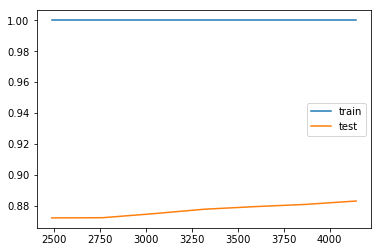

In [ ]:
ts = np.linspace(0.6, 1, 7)
train_sz, train_score, test_score = learning_curve(SVC(random_state=42, C=15), 
                                                   vect, y_train, cv=5, 
                                                   random_state=42,
                                                   scoring=scoring['f1'],
                                                   train_sizes=ts,
                                                   n_jobs=-1)
x, y = train_sz, np.mean(train_score, axis=1)
plt.plot(x, y, label='train')
x, y = train_sz, np.mean(test_score, axis=1)
plt.plot(x, y, label='test')
plt.legend();

In [ ]:
vect_test = [ft.get_sentence_vector(x) for x in X_test]

In [ ]:
model = SVC(random_state=42, C=15, probability=True)
model.fit(vect, y_train)
y_hat = model.predict(vect_test)
f1_score(y_test, y_hat)

0.8929219600725953

In [ ]:
roc_auc_score(y_test, model.predict_proba(vect_test)[:, 1])

0.9555978260869564

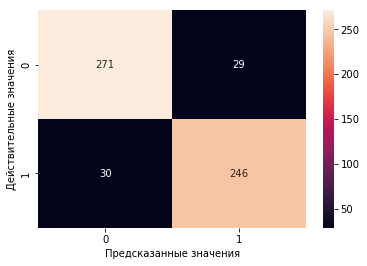

In [ ]:
class_names = [0, 1]
fig, ax = plt.subplots()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names)
plt.yticks(ticks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_hat)), annot=True, fmt='.3g')
plt.ylabel('Действительные значения')
plt.xlabel('Предсказанные значения');

*Хотя видно, что модель переобучена, а значит, можно еще усовершенствовать, SVC с гауссовым ядром показал лучшее качество на кросс-валидации из рассматриваемых моделей (0,883), хороший roc-auc-score (0,9556) и хорошую оценку на тестовой выборке (0,893). Поэтому его я и беру в финальную модель.*

### "Обучение и предсказание"

In [ ]:
ft = fasttext.load_model('cc.ru.300.bin')
vect = [ft.get_sentence_vector(x) for x in X]
model = SVC(random_state=42, C=15, probability=True)
model.fit(vect, Y)

SVC(C=15, probability=True, random_state=42)

In [ ]:
data_test = pd.read_csv('clean_data_test.csv')
data_test.head(3)

,is_fake,title_new
0,0,роскомнадзор представил реестр сочетаний цвето...
1,0,ночью под минском на президентской горе белара...
2,0,бывший спичрайтер юрия лозы рассказал о трудно...


In [ ]:
vect = [ft.get_sentence_vector(x) for x in data_test['title_new']]

In [ ]:
y_hat = model.predict(vect)

In [ ]:
data = pd.read_csv('test.tsv', sep='\t')
data['is_fake'] = y_hat
data.head(3)

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1


In [ ]:
data.to_csv('predictions.tsv', index=False, sep='\t')